## Abstract:

In this notebook I demonstrate some methods for improving the performance of nearest neighbour algorithms. This notebook serves as a smorgasbord of tactics to use to try and improve the results of nearest neighbour algorithms. 

### Contents:

- [Introduction and benchmark](#Introduction-and-benchmark)
- [Parameters: n_neighbors](#Parameters:-n_neighbors)
- [Parameters: metric and p](#Parameters:-metric-and-p)
- [Parameters: weights](#Parameters:-weights)
- [Basic scaling](#Basic-scaling)
- [Feature importance scaling](#Feature-importance-scaling)
- [ECDF scaling](#ECDF-scaling)
- [Feature selection](#Feature-selection)
- [Dimensionality reduction](#Dimensionality-reduction)
- [Advanced: learning metrics](#Advanced:-learning-metrics)
- [Summary](#Summary)

# Introduction and benchmark

A nearest neighbour algorithm works by finding samples in the training data that are similar to a query. The easiest interpretation of this is to think of the feature space as Euclidean space and say that two data points are similar if they are close together. In this section we will run a default nearest neigbours algorithm on a sample dataset and look at the options available.

In [2]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this dataset the target variable is the output from a power station. 

In [3]:
data = pd.read_excel("../../raw_data/Power.xlsx")

In [4]:
data.shape

(9568, 5)

In [5]:
data.head(n = 10)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


Briefly, the features are Atmospheric Temperature (AT), Exhaust Vacuum (V), Atmospheric pressure (AP) and Relative Humidity (RH), respectively. The target variable is the electrical energy output (PE). The dataset can be found at eh UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

First we split the data into features and the target and split the data into training and validation set.

In [6]:
X = data.drop('PE', axis = 1)
y = data.PE

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state = 1)

Let's take a look a quick at the options available in sci-kit learn.

In [8]:
from sklearn.neighbors import KNeighborsRegressor as KNR
model = KNR()
model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

The parameters: <i>algorithm</i> and <i>leaf_size</i> affect how the algorithm learns and produces predictions. There is a trade-off between finding the exact k-nearest neighbours and computational complexity. I am not going to explore these options any further here. You can find out more details by checking out the sklearn documentation. 

<i> n_jobs </i> controls parallel computing, by setting it to -1 the algorithm will automatically detect and use the maximum number of threads available. 

The remaining options truly affect the the behaviour of the algorithm and should be considered carefully. I the following sections I will explore these options and the work we can do to improve our algorithm's results. First let's get a benchmark result using all the default options.



In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

For this dataset I will use root mean squared error to measure performance.

In [10]:
from sklearn.metrics import mean_squared_error as mse

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [11]:
benchmark = RMSE(y_val, y_pred)
benchmark

3.7972230907015603

# Parameters: n_neighbors

The <i>n_neighbors</i> parameter decides how many neighbours are used. Once the k-nearest neighbours are located by the algorithm a prediction is returned by averaging the target for those neighbours. The numbers of neighbours used is essentially a trade off between bias and variance (as is many decisions we make!). For example, if we set n_neighbors = 1 we get a very flexible algorithm - too flexible in most cases - which means the variance is too high. On the other hand if we set n_neighbors very high we might as well take the global average of all the points. In this case the algorithm is too rigid; in other words biased.

While looking at the dataset and experience can give some guidance for suitable values of n_neighbors. However, it is easy enough to check a wide range of values.

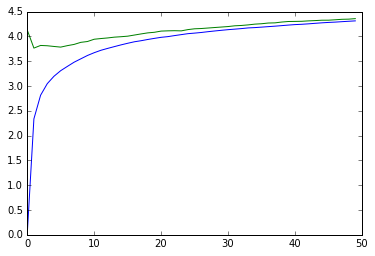

In [17]:
values = map(int, np.linspace(1, 50, 50))

train_results, val_results = [], []

for k in values:
    model = KNR(n_neighbors = k)
    model.fit(X_train, y_train)
    p_train = model.predict(X_train)
    p_val = model.predict(X_val)
    train_results.append( RMSE(y_train, p_train) )
    val_results.append( RMSE(y_val, p_val) )

   
plt.plot(train_results)
plt.plot(val_results)

The plot is very typical for k-nearest neighbours. Of course, the training error is zero for n_neighbors = 1 and increases the more neighbours you use. For the test set the error first decreases and then increases gently.

In [108]:
min(val_results), np.argmin(val_results)+1 # the list is zero indexed.

(3.7644036957452367, 2)

We have reduced the error just a tiny bit (less than 1%) by using 6 neighbours.

# Parameters: metric and p

The parameter <i>metric</i> determines the notion of distance in the sample space. It could be argued that this is the most important part of the algorithm as it determines which points are the k-nearest in the training data!

There are several distance functions built into sklearn's kNN algorithm and the user is welcome to define their own functions. In particular, there is a large number of distances for vectors of binary variables. Check out:

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

for supplied options. I am going to stick with the default metric for this example: the Minkowski metric. The parameter <i>p</i> is a special parameter that feeds into the Minkowski metric. If any other option is selected, then <i>p</i> does not do anything. Note: when in use, p must be greater than or equal to 1.

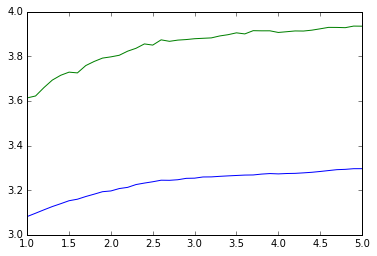

In [109]:
values = np.linspace(1, 5, 41)

train_results, val_results = [], []

for p in values:
    model = KNR(p = p)
    model.fit(X_train, y_train)
    p_train = model.predict(X_train)
    p_val = model.predict(X_val)
    train_results.append( RMSE(y_train, p_train) )
    val_results.append( RMSE(y_val, p_val) )

    
plt.plot(values, train_results)
plt.plot(values, val_results)

In this case $p = 1$ gives the best results for train and test. It is difficult to know what value of $p$ will work ahead of time. Again, I suggest a search as above to find the best value.

In [110]:
min(val_results), np.argmin(val_results)+1 # the list is zero indexed.

(3.6132892175079676, 1)

A more significant improvement this time.

Of course, we have used the default number of neighbours here. To get the best possible results we must tune both parameters - preferably at the same time. In general, the hyperparameters of machine learning algorithms are not independent. However, we will do this after we have explored the final main parameter of interest

# Parameters: weights

The k-nearest neighbour algorithm finds the k-nearest neighbours and then takes the average to make a prediction. The weights parameter allows us to control how the average is taken.

The sklearn has two inbuilt options <i>uniform</i> and <i>distance</i>. The uniform option takes the (arithmetic) mean of the k-nearest neighbours with our any consideration for the distance from the query point. Intuitively, this does not seem right, somehow, points nearer to the query point should influence the result more, right? Well, that's exactly what this parameter allows us to control. The inbuilt option <i>distance</i> weights the k-nearest neighbours by the inverse of their distance from the query point. For me, this feels better. However, the weighted stronly favours very close points and assigns them a lot of weight. 

In [111]:
xs = np.linspace(0, 10, 100)
ys = 5 * np.ones(100) # the 5 here does not affect the weights - it is for the graph only
zs = 1 / xs

In [1]:
with plt.style.context('fivethirtyeight'):
    plt.plot(xs, ys);
    plt.plot(xs, zs);

NameError: name 'plt' is not defined

The graphs illustrates the way the weightings work. In particular, anything with a distance less than 1 from from the qery point will contribute a lot more to the average than something a little over 2 away. I think this is a little extreme so I often work with some other weightings.

The following function gives a different weighting. Of course, closer points are still given a higher weighting but the initial penality for being a 'little bit' away is less severe. However, it heavily penalises points that are a 'little bit more' away.

In [113]:
def gaussian(x):
    return 10 * np.exp(-0.15 * np.power(x, 2)) #the 10 here doesn't affect the weights - it is for the graph only

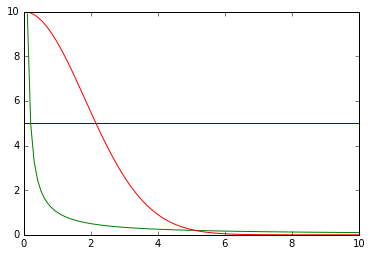

In [114]:
xs = np.linspace(0, 10, 100)
ws = gaussian(xs)

plt.plot(xs, ys);
plt.plot(xs, zs);
plt.plot(xs, ws)

I think that the plot tells the story nicely.

In [115]:
values = ['uniform', 'distance', gaussian]

train_results, val_results = [], []

for value in values:
    model = KNR(weights = value)
    model.fit(X_train, y_train)
    p_train = model.predict(X_train)
    p_val = model.predict(X_val)
    train_results.append( RMSE(y_train, p_train) )
    val_results.append( RMSE(y_val, p_val) )

print values
print train_results
print val_results

['uniform', 'distance', <function gaussian at 0x11b842398>]
[3.1964919177015192, 0.0, 2.7331368940580565]
[3.7972230907015603, 3.5812410425188439, 3.6325734089016892]


The distance options comes out on top with the home-made gaussian in a close second. Uniform performs much worse. In my experience distance usually out performs uniform, but - importantly - NOT always.

Now we turn to tuning n_neighbours, p and weights simultaneously. I will set up an evaluate function that includes a gridsearch for the best parameter using cross validation within the training data. In the following sections we will be preprocessing the dataset to make further improvement.

In [116]:
from sklearn.model_selection import GridSearchCV

def evaluate( X_train, X_val, y_train, y_val ):
    param_grid = {'weights': ['uniform', 'distance'], 
              'n_neighbors': [4, 5, 6, 7, 8, 9, 10], 
              'p':[1, 1.3, 1.6, 2]}
    clf = GridSearchCV(KNR(), param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 0, n_jobs = -1)
    clf.fit(X_train, y_train)
    print clf.best_estimator_
    p_val = clf.predict(X_val)
    print "RMSE: ", RMSE(y_val, p_val)


In [117]:
evaluate(X_train, X_val, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=1,
          weights='distance')
RMSE:  3.39438674849


This is our best result so far. We have made ~10% improvement on using the default parameters.

# Basic scaling

Scaling the data is key for nearest neighbours algorithms. Let's take a look at the dataset again to see why.

In [118]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [119]:
for col in data.columns:
    print col, data[col].std()

AT 7.45247322961
V 12.7078929983
AP 5.93878370581
RH 14.6002687567
PE 17.0669949998


Despite being on quite different scales (AT values ranges from 0-40 and AP values near to 1000), we see that the standard deviations of the four features are fairly similar. However, the standard deviation of RH is 2-3 times that of AP and AT. For nearest neighbours this is very important! A relative difference in RH will make more of impact to the distance between points than say AT or AP - this is important especially if RH is a weaker feature (we will see later that RH is in fact the weakest feature in this set!) 

There are several options in sklearn for rescaling the data.

1. StandardScaler: rescale data to have mean zero and standard deviation one.
2. MinMaxScaler: rescale the data to [0,1]
3. RobustScaler: rescale the data based on the median and IQR (or another range of our choicing).
3. MaxAbsScaler: scale features based on the largest absolute value.

Let's try each one and see if we can make any progress.

In [120]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

In [121]:
standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler(quantile_range=(25.0, 75.))
maxabs = MaxAbsScaler()

In [122]:
standard.fit(X_train)
X_train_standard = standard.transform(X_train)
X_val_standard= standard.transform(X_val)
evaluate(X_train_standard, X_val_standard, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=1,
          weights='distance')
RMSE:  3.27017468236


In [123]:
minmax.fit(X_train)
X_train_minmax = minmax.transform(X_train)
X_val_minmax = minmax.transform(X_val)
evaluate(X_train_minmax, X_val_minmax, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=1,
          weights='distance')
RMSE:  3.21566876933


In [124]:
robust.fit(X_train)
X_train_robust = robust.transform(X_train)
X_val_robust = robust.transform(X_val)
evaluate(X_train_robust, X_val_robust, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=1,
          weights='distance')
RMSE:  3.37173787903


In [125]:
maxabs.fit(X_train)
X_train_maxabs = maxabs.transform(X_train)
X_val_maxabs = maxabs.transform(X_val)
evaluate(X_train_maxabs, X_val_maxabs, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=1,
          weights='distance')
RMSE:  3.52326245043


In [126]:
print 'Benchmark: ', 3.39438674849
print 'Standard:  ', 3.27017468236
print 'MinMax:    ', 3.21566876933
print 'Robust:    ', 3.37173787903
print 'MaxAbs:    ', 3.52326245043

Benchmark:  3.39438674849
Standard:   3.27017468236
MinMax:     3.21566876933
Robust:     3.37173787903
MaxAbs:     3.52326245043


StandardScaler and MinMaxScaler make an improvement on the benchmark. On the other hand, MaxAbsScaler actually makes the problem worse in this case! Let's take a look at the data after scaling by MaxAbsScaler:

In [127]:
X_train_maxabs

array([[ 0.6453786 ,  0.71677293,  0.98470918,  0.68350639],
       [ 0.35273511,  0.51029917,  0.97921223,  0.83007188],
       [ 0.4244139 ,  0.49031388,  0.97456692,  0.77316294],
       ..., 
       [ 0.50094314,  0.48479647,  0.97605729,  0.68500399],
       [ 0.61870116,  0.55186366,  0.97958966,  0.50728834],
       [ 0.55241175,  0.60924473,  0.97706378,  0.70696885]])

The problem is the AP column, since all of the data is near 1000, division by 1000 leaves very little variation in the data. The MinMaxScaler 'wins'.

# Feature importance scaling

In the previous section we saw that scaling the features puts them on a level playing field. On the other hand we can now adjust the scaling in order to give more important feature more sway. There are many ways to measure feature importance, each with pro and cons. I am going to try a simple option here: correlation with the target variable. Correlation may not be the best way to measure feature importance. Let me explain with a quick example.

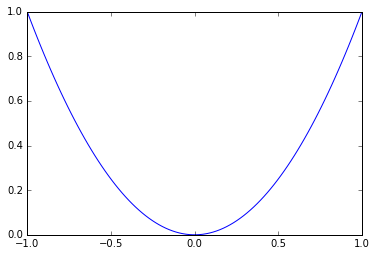

In [128]:
xs = np.linspace(-1, 1, 100)
ys = xs**2

plt.plot(xs, ys)

In [129]:
np.corrcoef(xs, ys)[0,1]

2.5253386692946614e-16

Here the ys are depend deterministically on the xs, but the correlation is zero (essentially). As such, using correlation only really makes sense if we know our data!

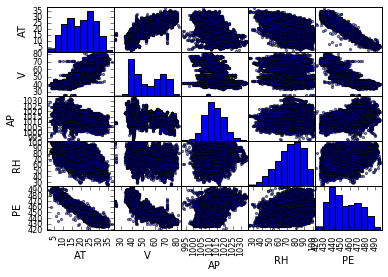

In [130]:
pd.scatter_matrix(pd.concat([X_train, y_train], axis = 1));

This does not look too non-linear. Correlation seems like a reasonable measure to use for these variables. (look at the right-hand column or the bottom row for the plot between each feature and the target variable.)

In [131]:
for col in X_train.columns:
    print col, np.corrcoef(X_train[col], y_train)[1, 0]

AT -0.947190696586
V -0.870412453491
AP 0.515557098731
RH 0.386259425484


I am moving forawrd with the MinMaxScaler and now applying the 'correlation scale' on top of that.

In [132]:
X_train_minmax_corr = X_train_minmax.copy()
X_train_minmax_corr[:, 0] = 0.95 * X_train_minmax_corr[:, 0]
X_train_minmax_corr[:, 1] = 0.87 * X_train_minmax_corr[:, 1]
X_train_minmax_corr[:, 2] = 0.52 * X_train_minmax_corr[:, 2]
X_train_minmax_corr[:, 3] = 0.39 * X_train_minmax_corr[:, 3]

X_val_minmax_corr = X_val_minmax.copy()
X_val_minmax_corr[:, 0] = 0.95 * X_val_minmax_corr[:, 0]
X_val_minmax_corr[:, 1] = 0.87 * X_val_minmax_corr[:, 1]
X_val_minmax_corr[:, 2] = 0.52 * X_val_minmax_corr[:, 2]
X_val_minmax_corr[:, 3] = 0.39 * X_val_minmax_corr[:, 3]

In [133]:
evaluate(X_train_minmax_corr, X_val_minmax_corr, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=1,
          weights='distance')
RMSE:  3.10835477547


A ~3% improvement. I would definitely want to consider other ways of measuring feature importance. The clear gain here shows its value in scaling the data and directly altering each feature's impact on the model.

# ECDF scaling

All of the scaling so far has been linear. Specifically, of the form:
$$
x \rightarrow \frac{x - a}{b}.
$$
The aim of this kind of scaling was to put the features on the same level. We then applied 'correlation scaling' to increase the influence of the more important features.

I am now going to implement an idea I have not seen elsewhere. I was trying to think of other ways of scaling the data to [0,1] when I realised the the CDF (cumulative distribution function) has that kind of property.

However, transforming the data using the ECDF (empirical CDF) of each feature changes the distances in another way. Relatively, it spreads data out in the areas of high density and compresses distances in areas of low density. This appeals to me. In the areas of high density it allows us to be more discerning in the selection of our nearest neighbours.

In [134]:
from statsmodels.distributions.empirical_distribution import ECDF

X_train_ecdf = X_train.copy()
X_val_ecdf = X_val.copy()

for col in X_train_ecdf.columns:
    ecdf = ECDF(X_train_ecdf[col])
    X_train_ecdf[col] = map(ecdf, X_train_ecdf[col])
    X_val_ecdf[col] = map(ecdf, X_val_ecdf[col])

In [135]:
evaluate(X_train_ecdf, X_val_ecdf, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=1,
          weights='distance')
RMSE:  3.25009398861


This is a little behind the MinMaxScaler but ahead of the rest of the scaling methods from that section. Now, let's add correlation scaling to the mix as well.

In [156]:
for col in X_train_ecdf.columns:
    print col, np.corrcoef(X_train_ecdf[col], y_train)[1, 0]

AT -0.942322477415
V -0.876684209367
AP 0.526404574669
RH 0.384707913754


In [159]:
X_train_ecdf_corr = X_train_ecdf.copy().values
X_train_ecdf_corr[:, 0] = 0.94 * X_train_ecdf_corr[:, 0]
X_train_ecdf_corr[:, 1] = 0.88 * X_train_ecdf_corr[:, 1]
X_train_ecdf_corr[:, 2] = 0.53 * X_train_ecdf_corr[:, 2]
X_train_ecdf_corr[:, 3] = 0.38 * X_train_ecdf_corr[:, 3]

X_val_ecdf_corr = X_val_ecdf.copy().values
X_val_ecdf_corr[:, 0] = 0.94 * X_val_ecdf_corr[:, 0]
X_val_ecdf_corr[:, 1] = 0.88 * X_val_ecdf_corr[:, 1]
X_val_ecdf_corr[:, 2] = 0.53 * X_val_ecdf_corr[:, 2]
X_val_ecdf_corr[:, 3] = 0.38 * X_val_ecdf_corr[:, 3]

In [160]:
evaluate(X_train_ecdf_corr, X_val_ecdf_corr, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='distance')
RMSE:  2.95549862704


One final trick before we move on to a different topic. We can apply a transformation to the values we use to scale. The idea here is that there is nothing special about the correlations - they just show which feature might have more value. By exponentiating the values by a number larger than 1, say 1.25, we are further increasing the influence of the more important features as they as modified less relative to the lower numbers. Of course, we could ameliorate their influence by setting the exponent less than one.

In [173]:
power = 1.25

X_train_ecdf_corr = X_train_ecdf.copy().values
X_train_ecdf_corr[:, 0] = 0.94**power * X_train_ecdf_corr[:, 0]
X_train_ecdf_corr[:, 1] = 0.88**power * X_train_ecdf_corr[:, 1]
X_train_ecdf_corr[:, 2] = 0.53**power * X_train_ecdf_corr[:, 2]
X_train_ecdf_corr[:, 3] = 0.38**power * X_train_ecdf_corr[:, 3]

X_val_ecdf_corr = X_val_ecdf.copy().values
X_val_ecdf_corr[:, 0] = 0.94**power * X_val_ecdf_corr[:, 0]
X_val_ecdf_corr[:, 1] = 0.88**power * X_val_ecdf_corr[:, 1]
X_val_ecdf_corr[:, 2] = 0.53**power * X_val_ecdf_corr[:, 2]
X_val_ecdf_corr[:, 3] = 0.38**power * X_val_ecdf_corr[:, 3]

In [174]:
evaluate(X_train_ecdf_corr, X_val_ecdf_corr, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='distance')
RMSE:  2.9201874282


We have broken the 3.0 barrier. We have made a large improvement since the beginning of this notebook. Around 22% reduction in error overall. A small amount of data preprocessing and hyperparameter tuning was all it took!

WARNING: by trying so many different approaches and testing them against X_test we are in grave danger of overfitting to that particular set. In fact we hace really been using X_test as a validation set or a development set depending on your choice of nomenclature.

# Feature selection

In general, k-nearest neighbours suffers from the 'curse of dimensionality'. In essence, in a high dimensional space, everything is far away from everything so that the nearest neighbours are not really that near. Suppose our data has $d$ features. A rule of thumb is that we would like to have much more than $2^d$ samples. For $d<10$ this is not normally a problem as $2^10 = 1024$. However, by time we get to $d = 20$ we would like to have 'much more' than a million samples.

One way to deal with this problem is to eliminate features. In our case we only have four features so this really is not a problem but let's explore anyway.

One approach to feature selection is to run models with all possible subsets of the features in play. For a larger number of features this becomes too computationally expensive. In that case forward greedy or backwardgreedy approaches can be used. Alternatively, we can eliminate features based on a measure of feature importance.

A bonus of eliminately features in larger datasets is it allows to run many more models and experiment more in the same period of time.

In [140]:
from itertools import combinations

for i in range(1, 5):
    for el in combinations(X.columns, i):
        
        X_train_temp = X_train[list(el)]
        X_val_temp = X_val[list(el)]
        
        model = KNR()
        model.fit(X_train_temp, y_train)
        preds = model.predict(X_val_temp)
        error = np.sqrt(mse(y_val, preds))
        
        
        print el, error

(u'AT',) 5.47491089204
(u'V',) 5.3403198513
(u'AP',) 15.9180599486
(u'RH',) 17.690583179
(u'AT', u'V') 4.16156782012
(u'AT', u'AP') 4.91666165758
(u'AT', u'RH') 4.69066814705
(u'V', u'AP') 6.28542186776
(u'V', u'RH') 7.99589058016
(u'AP', u'RH') 13.3687192104
(u'AT', u'V', u'AP') 3.50526726656
(u'AT', u'V', u'RH') 3.94459496351
(u'AT', u'AP', u'RH') 4.48656340961
(u'V', u'AP', u'RH') 6.56647390189
(u'AT', u'V', u'AP', u'RH') 3.7972230907


It turns out that removing 'Relative Humidity' (RH) actually improves the model. In the beginning of the section on scaling we found that RH has the highest standard deviation in the unscaled dataset and therefore was the most controlling feature in the kNN model.

In [141]:
X_train_feat = X_train[['AT', 'V', 'AP']]
X_val_feat = X_val[['AT', 'V', 'AP']]

In [142]:
evaluate(X_train_feat, X_val_feat, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=1,
          weights='distance')
RMSE:  3.26525140171


This result can be improved further with scaling, correlation scaling, ecdf scaling etc but I was unable to get close to 3.0. The conclusion is simple: we need RH in the model but with only a little influence.

# Dimensionality reduction

Rather than removing features, another option is dimensionality reduction. There are several options but the most popular is PCA. As above, we only have four features so no need to do this really, but let's walk through the steps and see what we get.

In [143]:
from sklearn.decomposition import PCA

In [144]:
pca = PCA(n_components = 3)

In [145]:
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

In [146]:
evaluate(X_train_pca, X_val_pca, y_train, y_val)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')
RMSE:  4.99110532102


In this case there really is no need to reduce dimensionality. Cutting down to three dimensions loses information and it shows in the error.

# Advanced: learning metrics

A lot of the work in the above sections revolved around trying to make sure the the nearest neighbours were actually nearest. We manipulated the distances to emphasize the most important features and suppress the irrelevant (or rather less relevant). 

An alternative approach is to learn a metric from the data. There are a lot methods for this. A good starting point is: https://all-umass.github.io/metric-learn/. the metric learn packages contains a number of different methods that have roughly the same goal.

These techniques are most useful in classification problems. The overall goal is to transform the feature space to move points in the same class together and away from points in other classes.

Here I will demonstrate a toy example, so we can really see what happens.

In [147]:
xs = [5, 5.5, 6, 5.4, 5.1, 5.6, 5.7]
ys = [5.1, 4.9, 5.2, 4.6, 4.4, 4.5, 4.6]
labels = (1, 1, 1, 0,0,0,0)
colors = ['blue' if x == 1 else 'orange' for x in labels]

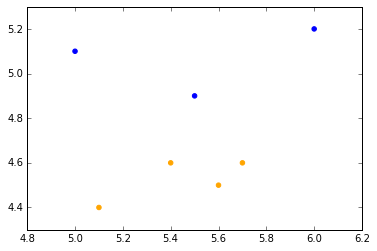

In [148]:
plt.scatter(xs, ys, color = colors);

We have two nicely separably classes, the blue points are actually quite far apart. In particular, the central blue point is much closer to the other class. A LMNN (large margin nearest neighbours) will try to push the separate classes apart. For LMNN the transformation learning is linear (eg a matrix) so nothing too crazy can happen, especially in 2 dimensions.

In [149]:
X = np.array([xs, ys]).T
y = labels

In [150]:
from metric_learn.lmnn import LMNN

In [151]:
lmnn = LMNN(k = 2, learn_rate = 1e-3, min_iter = 500, max_iter = 1000, verbose = False, regularization = 0)

In [152]:
lmnn.fit(X, y);

In [153]:
X_lmnn = lmnn.transform(X)

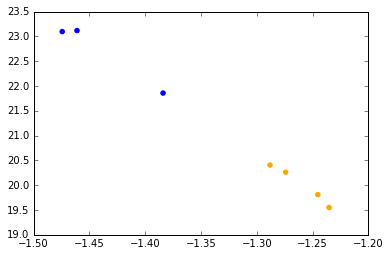

In [154]:
plt.scatter(X_lmnn[:, 0], X_lmnn[:, 1], color = colors);

Looking at the original plot it seems like the x direction is not important. It should not be a surprise to see that the LMNN has almost transformed the data on to a 1-dimensional subspace. While not entirely clear, the middle blue dot is now relatively closer to the other blue points than before the transformation

# Summary

k-nearest neighbours is a great alorithm; it is simple and, often effective. However, it is non-trivial to get the best results from the algorithm. Care must be taken to transform the underlying data or to pick a distance so that the algorithm really finds the k most similar points.